In [1]:
# =========================================================
# 0) Environment & Imports
# =========================================================
import os
import math
import random
import hashlib
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
import torchvision.models as models

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import matplotlib.pyplot as plt

# =========================================================
# Hardware
# =========================================================
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("DEVICE:", DEVICE)

DEVICE: cuda


## 1) Configuration

Notes:
- The reference paper resizes images to **416×416**. This notebook defaults to **416** for protocol alignment.
- If you want faster training, change `IMG_SIZE` to **224**.

In [2]:
@dataclass
class Config:
    ROOT: str = "./Meat Freshness.v1-new-dataset.multiclass"  # change if needed

    # Protocol alignment vs speed tradeoff
    IMG_SIZE: int = 416      # paper-style: 416; faster: 224
    BATCH_SIZE: int = 16     # adjust for GPU memory
    NUM_WORKERS: int = 4

    # Split strategy
    TEST_SIZE: float = 0.30      # 70/30 like the paper
    VAL_FROM_TRAIN: float = 0.20 # fraction of train reserved for validation (early stopping)

    # Training
    EPOCHS: int = 30
    LR: float = 3e-4
    WEIGHT_DECAY: float = 0.0

    # Early stopping
    PATIENCE: int = 5
    MIN_DELTA: float = 0.01

    # Reproducibility
    BASE_SEED: int = 2023
    DETERMINISTIC: bool = False  # True can reduce speed

    # Saving
    SAVE_DIR: str = "saved_models"
    SAVE_PREFIX: str = "meat_resnet50"

cfg = Config()
print(cfg)

Config(ROOT='./Meat Freshness.v1-new-dataset.multiclass', IMG_SIZE=416, BATCH_SIZE=16, NUM_WORKERS=4, TEST_SIZE=0.3, VAL_FROM_TRAIN=0.2, EPOCHS=30, LR=0.0003, WEIGHT_DECAY=0.0, PATIENCE=5, MIN_DELTA=0.01, BASE_SEED=2023, DETERMINISTIC=False, SAVE_DIR='saved_models', SAVE_PREFIX='meat_resnet50')


In [3]:
# =========================================================
# 2) Reproducibility Utilities
# =========================================================
def set_seed(seed: int, deterministic: bool = False):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    else:
        torch.backends.cudnn.benchmark = True

set_seed(cfg.BASE_SEED, cfg.DETERMINISTIC)

## 3) Data Loading

This section:
- Finds images under `train/` and `valid/` (supports optional `images/` subfolder).
- Builds a unified list of `(path, label)` samples.
- Performs a **stratified 70/30 split** (train/test), then a stratified split of train into train/val.

In [4]:
IMG_EXTS = (".jpg", ".jpeg", ".png", ".bmp", ".webp")

def resolve_image_dir(base: Path) -> Path:
    # Return base/images if it exists, otherwise base
    if (base / "images").exists():
        return base / "images"
    return base

def list_images(folder: Path):
    files = []
    for ext in IMG_EXTS:
        files.extend(folder.rglob(f"*{ext}"))
        files.extend(folder.rglob(f"*{ext.upper()}"))
    # unique + stable order
    return sorted(set(files))

def infer_class_from_filename(path: str) -> str:
    # Example: "FRESH-123.jpg" -> "FRESH"
    return os.path.basename(path).split("-")[0]

def load_samples(root: str):
    root = Path(root)
    train_dir = resolve_image_dir(root / "train")
    valid_dir = resolve_image_dir(root / "valid")

    if not train_dir.exists() or not valid_dir.exists():
        raise FileNotFoundError(
            f"Expected train/ and valid/ under: {root}\n"
            f"Found train_dir={train_dir.exists()}, valid_dir={valid_dir.exists()}"
        )

    train_paths = list_images(train_dir)
    valid_paths = list_images(valid_dir)
    all_paths = train_paths + valid_paths

    if len(all_paths) == 0:
        raise FileNotFoundError(f"No images found under {train_dir} or {valid_dir}.")

    class_names = sorted(list({infer_class_from_filename(str(p)) for p in all_paths}))
    class_to_idx = {c: i for i, c in enumerate(class_names)}

    samples = [(str(p), class_to_idx[infer_class_from_filename(str(p))]) for p in all_paths]
    return samples, class_to_idx

samples, classes = load_samples(cfg.ROOT)

print("Total images:", len(samples))
print("Classes:", classes)

idx_to_class = {v: k for k, v in classes.items()}

# Class distribution
counts = {}
for _, y in samples:
    counts[y] = counts.get(y, 0) + 1
print("Distribution:", {idx_to_class[k]: v for k, v in counts.items()})

Total images: 2266
Classes: {'FRESH': 0, 'HALF': 1, 'SPOILED': 2}
Distribution: {'FRESH': 853, 'HALF': 789, 'SPOILED': 624}


### 3.1 Stratified Train/Val/Test Split (Paper-style 70/30 Test)

We first split **train/test** using `TEST_SIZE=0.30` (like the paper).
Then we take `VAL_FROM_TRAIN=0.20` from the training portion for validation (early stopping).

In [5]:
X_paths = np.array([p for p, _ in samples])
y_labels = np.array([y for _, y in samples])

# Train/Test (70/30)
X_train, X_test, y_train, y_test = train_test_split(
    X_paths, y_labels,
    test_size=cfg.TEST_SIZE,
    random_state=cfg.BASE_SEED,
    stratify=y_labels
)

# Train/Val (from train portion)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=cfg.VAL_FROM_TRAIN,
    random_state=cfg.BASE_SEED,
    stratify=y_train
)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))

def show_split_distribution(y, name):
    u, c = np.unique(y, return_counts=True)
    dist = {idx_to_class[int(uu)]: int(cc) for uu, cc in zip(u, c)}
    print(f"{name} distribution:", dist)

show_split_distribution(y_train, "Train")
show_split_distribution(y_val, "Val")
show_split_distribution(y_test, "Test")

Train: 1268 Val: 318 Test: 680
Train distribution: {'FRESH': 477, 'HALF': 441, 'SPOILED': 350}
Val distribution: {'FRESH': 120, 'HALF': 111, 'SPOILED': 87}
Test distribution: {'FRESH': 256, 'HALF': 237, 'SPOILED': 187}


## 4) Optional: Exact-Duplicate Leakage Check (MD5)

This cell computes a file hash for each image to detect **exact duplicates** across splits.
If duplicates exist across train and test, your accuracy may be inflated.

For large datasets this can take time; you can skip it if needed.

In [7]:
def md5_file(path: str, chunk_size: int = 1 << 20) -> str:
    h = hashlib.md5()
    with open(path, "rb") as f:
        while True:
            b = f.read(chunk_size)
            if not b:
                break
            h.update(b)
    return h.hexdigest()

def compute_hashes(paths):
    return {p: md5_file(p) for p in paths}

# Recommended: run at least once.
# Uncomment to execute:

train_hashes = compute_hashes(X_train)
val_hashes   = compute_hashes(X_val)
test_hashes  = compute_hashes(X_test)

train_set = set(train_hashes.values())
val_set   = set(val_hashes.values())
test_set  = set(test_hashes.values())

print("Exact-duplicate overlaps (hash-based):")
print("Train ∩ Val :", len(train_set & val_set))
print("Train ∩ Test:", len(train_set & test_set))
print("Val ∩ Test  :", len(val_set & test_set))

Exact-duplicate overlaps (hash-based):
Train ∩ Val : 0
Train ∩ Test: 0
Val ∩ Test  : 0


## 5) PyTorch Dataset & DataLoaders

In [8]:
class MeatImageDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = list(paths)
        self.labels = list(labels)
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        p = self.paths[idx]
        y = int(self.labels[idx])
        img = Image.open(p).convert("RGB")
        if self.transform:
            img = self.transform(img)
        return img, y

mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
tfm = T.Compose([
    T.Resize((cfg.IMG_SIZE, cfg.IMG_SIZE)),
    T.ToTensor(),
    T.Normalize(mean=mean, std=std),
])

train_ds = MeatImageDataset(X_train, y_train, transform=tfm)
val_ds   = MeatImageDataset(X_val, y_val, transform=tfm)
test_ds  = MeatImageDataset(X_test, y_test, transform=tfm)

train_dl = DataLoader(train_ds, batch_size=cfg.BATCH_SIZE, shuffle=True,
                      num_workers=cfg.NUM_WORKERS, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=cfg.BATCH_SIZE, shuffle=False,
                      num_workers=cfg.NUM_WORKERS, pin_memory=True)
test_dl  = DataLoader(test_ds, batch_size=1, shuffle=False,
                      num_workers=cfg.NUM_WORKERS, pin_memory=True)

print("Batches - train:", len(train_dl), "val:", len(val_dl), "test:", len(test_dl))

Batches - train: 80 val: 20 test: 680


## 6) Model (Pretrained ResNet-50)

- Uses ImageNet-pretrained ResNet-50 from torchvision.
- Replaces the final FC layer to output `num_classes`.

In [9]:
def build_model(num_classes: int):
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

num_classes = len(classes)
model = build_model(num_classes).to(DEVICE)

print(model.fc)

/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Linear(in_features=2048, out_features=3, bias=True)


## 7) Training Loop (Early Stopping)

Key points:
- `model.train()` during training (BatchNorm updates correctly).
- `model.eval()` during validation.
- Early stopping monitors validation loss with `MIN_DELTA` and `PATIENCE`.

In [14]:
from tqdm import tqdm
def to_device(batch):
    ims, gts = batch
    return ims.to(DEVICE, non_blocking=True), torch.as_tensor(gts, device=DEVICE).long()

def train_one_epoch(model, loader, loss_fn, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0

    for ims, gts in tqdm(loader, desc="train", leave=False):
        ims, gts = to_device((ims, gts))

        optimizer.zero_grad(set_to_none=True)
        logits = model(ims)
        loss = loss_fn(logits, gts)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        correct += (logits.argmax(dim=1) == gts).sum().item()

    return running_loss / len(loader), correct / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, loss_fn):
    model.eval()
    running_loss = 0.0
    correct = 0

    for ims, gts in tqdm(loader, desc="val", leave=False):
        ims, gts = to_device((ims, gts))

        logits = model(ims)
        loss = loss_fn(logits, gts)

        running_loss += loss.item()
        correct += (logits.argmax(dim=1) == gts).sum().item()

    return running_loss / len(loader), correct / len(loader.dataset)

def fit(model, train_dl, val_dl, cfg, seed):
    set_seed(seed, cfg.DETERMINISTIC)

    os.makedirs(cfg.SAVE_DIR, exist_ok=True)
    ckpt_path = os.path.join(cfg.SAVE_DIR, f"{cfg.SAVE_PREFIX}_seed{seed}_best.pth")

    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=cfg.LR, weight_decay=cfg.WEIGHT_DECAY)

    best_loss = float("inf")
    epochs_no_improve = 0
    history = []

    for epoch in range(cfg.EPOCHS):
        tr_loss, tr_acc = train_one_epoch(model, train_dl, loss_fn, optimizer)
        val_loss, val_acc = evaluate(model, val_dl, loss_fn)

        history.append({
            "epoch": epoch + 1,
            "train_loss": tr_loss,
            "train_acc": tr_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
        })

        print(f"Epoch {epoch+1:02d} | train_loss={tr_loss:.4f}, train_acc={tr_acc:.4f} | val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

        # Early stopping on validation loss
        if val_loss < (best_loss - cfg.MIN_DELTA):
            best_loss = val_loss
            epochs_no_improve = 0
            torch.save(model.state_dict(), ckpt_path)
            print("  Saved best checkpoint.")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= cfg.PATIENCE:
                print(f"  Early stop (no val_loss improvement for {cfg.PATIENCE} epochs).")
                break

    return ckpt_path, pd.DataFrame(history)

# ---- Train once (single-seed, portfolio run) ----
seed = cfg.BASE_SEED
model = build_model(num_classes).to(DEVICE)
best_ckpt, history_df = fit(model, train_dl, val_dl, cfg, seed)
history_df.tail()

Epoch 01 | train_loss=0.3559, train_acc=0.8446 | val_loss=0.2757, val_acc=0.8962
  Saved best checkpoint.


Epoch 02 | train_loss=0.1188, train_acc=0.9535 | val_loss=0.0582, val_acc=0.9780
  Saved best checkpoint.


Epoch 03 | train_loss=0.0740, train_acc=0.9732 | val_loss=0.3438, val_acc=0.8836


Epoch 04 | train_loss=0.0884, train_acc=0.9653 | val_loss=0.1240, val_acc=0.9686


Epoch 05 | train_loss=0.0406, train_acc=0.9834 | val_loss=0.0254, val_acc=0.9906
  Saved best checkpoint.


Epoch 06 | train_loss=0.0540, train_acc=0.9842 | val_loss=0.0553, val_acc=0.9843


Epoch 07 | train_loss=0.0558, train_acc=0.9819 | val_loss=0.0447, val_acc=0.9906


Epoch 08 | train_loss=0.0818, train_acc=0.9716 | val_loss=0.0237, val_acc=0.9969


Epoch 09 | train_loss=0.0200, train_acc=0.9945 | val_loss=0.0215, val_acc=0.9906


Epoch 10 | train_loss=0.0244, train_acc=0.9968 | val_loss=0.0103, val_acc=0.9969
  Saved best checkpoint.


Epoch 11 | train_loss=0.1284, train_acc=0.9614 | val_loss=0.0945, val_acc=0.9780


Epoch 12 | train_loss=0.0626, train_acc=0.9826 | val_loss=0.0250, val_acc=0.9874


Epoch 13 | train_loss=0.0147, train_acc=0.9961 | val_loss=0.0309, val_acc=0.9874


Epoch 14 | train_loss=0.0141, train_acc=0.9968 | val_loss=0.0788, val_acc=0.9843


Epoch 15 | train_loss=0.0686, train_acc=0.9826 | val_loss=0.0288, val_acc=0.9969
  Early stop (no val_loss improvement for 5 epochs).


,epoch,train_loss,train_acc,val_loss,val_acc
10,11,0.128402,0.961356,0.094526,0.977987
11,12,0.062621,0.982650,0.025000,0.987421
12,13,0.014702,0.996057,0.030863,0.987421
13,14,0.014061,0.996845,0.078820,0.984277
14,15,0.068619,0.982650,0.028801,0.996855


### 7.1 Training Curves

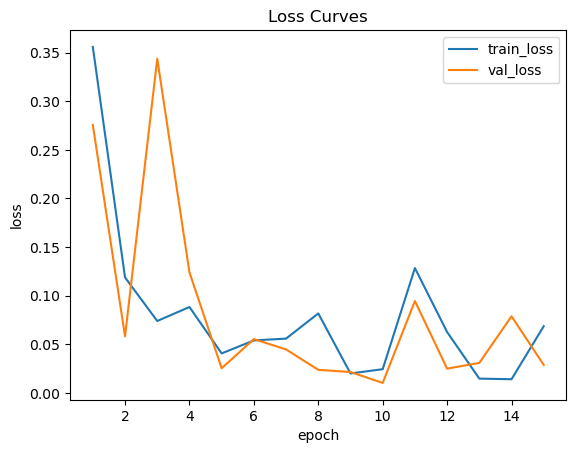

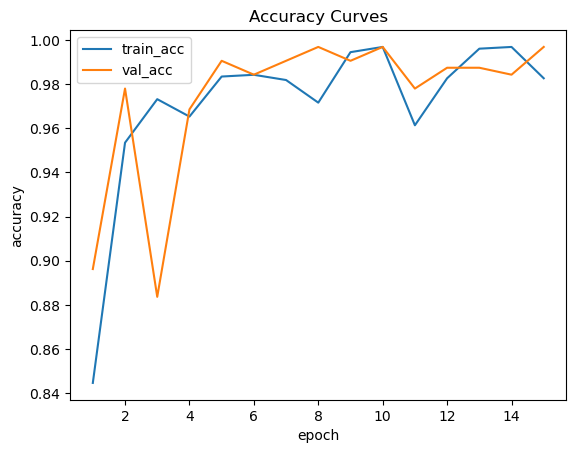

In [15]:
plt.figure()
plt.plot(history_df["epoch"], history_df["train_loss"], label="train_loss")
plt.plot(history_df["epoch"], history_df["val_loss"], label="val_loss")
plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.title("Loss Curves")
plt.show()

plt.figure()
plt.plot(history_df["epoch"], history_df["train_acc"], label="train_acc")
plt.plot(history_df["epoch"], history_df["val_acc"], label="val_acc")
plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.title("Accuracy Curves")
plt.show()

## 8) Test Evaluation (Confusion Matrix + Report + Macro Sensitivity/Specificity)

Definitions:
- **Sensitivity (Recall)** per class: TP / (TP + FN)
- **Specificity** per class: TN / (TN + FP)

We compute one-vs-rest specificity for each class and report the macro average.

In [16]:
@torch.no_grad()
def predict(model, loader):
    model.eval()
    y_true, y_pred = [], []
    for ims, gts in tqdm(loader, desc="test", leave=False):
        ims = ims.to(DEVICE, non_blocking=True)
        gts = torch.as_tensor(gts, device=DEVICE).long()

        logits = model(ims)
        pred = logits.argmax(dim=1)

        y_true.append(int(gts.item()))
        y_pred.append(int(pred.item()))
    return np.array(y_true), np.array(y_pred)

def macro_sensitivity_specificity(cm: np.ndarray):
    # cm: (K, K)
    K = cm.shape[0]
    total = cm.sum()
    sens, spec = [], []

    for c in range(K):
        TP = cm[c, c]
        FN = cm[c, :].sum() - TP
        FP = cm[:, c].sum() - TP
        TN = total - (TP + FN + FP)

        sensitivity = TP / (TP + FN + 1e-12)
        specificity = TN / (TN + FP + 1e-12)

        sens.append(sensitivity)
        spec.append(specificity)

    return float(np.mean(sens)), float(np.mean(spec)), sens, spec

# Load best checkpoint from the single-seed run
model = build_model(num_classes).to(DEVICE)
model.load_state_dict(torch.load(best_ckpt, map_location=DEVICE))
model.eval()

y_true, y_pred = predict(model, test_dl)

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix (rows=True, cols=Pred):\n", cm)

target_names = [idx_to_class[i] for i in range(len(idx_to_class))]

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

macro_sens, macro_spec, sens_list, spec_list = macro_sensitivity_specificity(cm)
print(f"\nMacro Sensitivity (Recall):  {macro_sens:.4f}")
print(f"Macro Specificity:          {macro_spec:.4f}")

pd.DataFrame({
    "class": target_names,
    "sensitivity(recall)": sens_list,
    "specificity": spec_list,
})

/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
                                                        

Confusion Matrix (rows=True, cols=Pred):
 [[249   7   0]
 [  0 237   0]
 [  0   0 187]]

Classification Report:

              precision    recall  f1-score   support

       FRESH     1.0000    0.9727    0.9861       256
        HALF     0.9713    1.0000    0.9854       237
     SPOILED     1.0000    1.0000    1.0000       187

    accuracy                         0.9897       680
   macro avg     0.9904    0.9909    0.9905       680
weighted avg     0.9900    0.9897    0.9897       680


Macro Sensitivity (Recall):  0.9909
Macro Specificity:          0.9947


,class,sensitivity(recall),specificity
0,FRESH,0.972656,1.000000
1,HALF,1.000000,0.984199
2,SPOILED,1.000000,1.000000


### 8.1 Confusion Matrix Plot

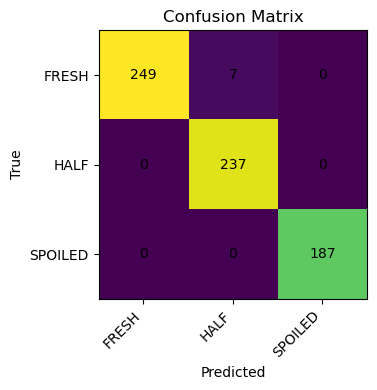

In [17]:
plt.figure(figsize=(5, 4))
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(range(len(target_names)), target_names, rotation=45, ha="right")
plt.yticks(range(len(target_names)), target_names)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()
plt.show()

## 9) Multi-Seed Benchmark (Mean ± Std)

Many papers report performance across multiple independent runs.
This section trains the model for multiple seeds and summarizes test metrics.

Tip: If runtime is a concern, reduce `SEEDS` or set `EPOCHS` smaller.

In [18]:
def run_one_seed(seed: int):
    model = build_model(num_classes).to(DEVICE)
    ckpt, _ = fit(model, train_dl, val_dl, cfg, seed)

    model = build_model(num_classes).to(DEVICE)
    model.load_state_dict(torch.load(ckpt, map_location=DEVICE))
    y_true, y_pred = predict(model, test_dl)
    cm = confusion_matrix(y_true, y_pred)

    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    acc = float(report["accuracy"])
    macro_rec = float(report["macro avg"]["recall"])
    macro_f1 = float(report["macro avg"]["f1-score"])
    macro_sens, macro_spec, _, _ = macro_sensitivity_specificity(cm)

    return {
        "seed": seed,
        "accuracy": acc,
        "macro_recall": macro_rec,
        "macro_f1": macro_f1,
        "macro_sensitivity": float(macro_sens),
        "macro_specificity": float(macro_spec),
        "ckpt": ckpt,
    }

SEEDS = [2023, 7, 42, 123, 999]

results = []
for s in SEEDS:
    print("\n" + "="*60)
    print("Running seed:", s)
    results.append(run_one_seed(s))

res_df = pd.DataFrame(results)
res_df


Running seed: 2023


/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 01 | train_loss=0.3245, train_acc=0.8770 | val_loss=0.3657, val_acc=0.8774
  Saved best checkpoint.


Epoch 02 | train_loss=0.1354, train_acc=0.9527 | val_loss=0.0799, val_acc=0.9748
  Saved best checkpoint.


Epoch 03 | train_loss=0.1260, train_acc=0.9558 | val_loss=0.1749, val_acc=0.9277


Epoch 04 | train_loss=0.0900, train_acc=0.9653 | val_loss=0.0901, val_acc=0.9748


Epoch 05 | train_loss=0.0337, train_acc=0.9874 | val_loss=0.0808, val_acc=0.9748


Epoch 06 | train_loss=0.0670, train_acc=0.9748 | val_loss=0.0311, val_acc=0.9874
  Saved best checkpoint.


Epoch 07 | train_loss=0.0198, train_acc=0.9953 | val_loss=0.0126, val_acc=0.9969
  Saved best checkpoint.


Epoch 08 | train_loss=0.0173, train_acc=0.9937 | val_loss=0.0183, val_acc=0.9937


Epoch 09 | train_loss=0.0195, train_acc=0.9953 | val_loss=0.0517, val_acc=0.9780


Epoch 10 | train_loss=0.0094, train_acc=0.9984 | val_loss=0.0311, val_acc=0.9874


Epoch 11 | train_loss=0.0342, train_acc=0.9905 | val_loss=0.1262, val_acc=0.9497


Epoch 12 | train_loss=0.1129, train_acc=0.9621 | val_loss=0.2134, val_acc=0.9340
  Early stop (no val_loss improvement for 5 epochs).


/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Running seed: 7


Epoch 01 | train_loss=0.2699, train_acc=0.8975 | val_loss=0.2753, val_acc=0.9088
  Saved best checkpoint.


Epoch 02 | train_loss=0.1451, train_acc=0.9432 | val_loss=0.2872, val_acc=0.9151


Epoch 03 | train_loss=0.0922, train_acc=0.9724 | val_loss=0.0768, val_acc=0.9686
  Saved best checkpoint.


Epoch 04 | train_loss=0.0516, train_acc=0.9811 | val_loss=0.1316, val_acc=0.9591


Epoch 05 | train_loss=0.0381, train_acc=0.9850 | val_loss=0.0520, val_acc=0.9843
  Saved best checkpoint.


Epoch 06 | train_loss=0.0536, train_acc=0.9913 | val_loss=0.7910, val_acc=0.8459


Epoch 07 | train_loss=0.1012, train_acc=0.9669 | val_loss=0.0786, val_acc=0.9623


Epoch 08 | train_loss=0.1089, train_acc=0.9661 | val_loss=0.1582, val_acc=0.9340


Epoch 09 | train_loss=0.0354, train_acc=0.9874 | val_loss=0.0398, val_acc=0.9874
  Saved best checkpoint.


Epoch 10 | train_loss=0.0431, train_acc=0.9826 | val_loss=0.0388, val_acc=0.9811


Epoch 11 | train_loss=0.0096, train_acc=0.9976 | val_loss=0.0224, val_acc=0.9874
  Saved best checkpoint.


Epoch 12 | train_loss=0.0173, train_acc=0.9953 | val_loss=0.0778, val_acc=0.9811


Epoch 13 | train_loss=0.0208, train_acc=0.9929 | val_loss=0.0543, val_acc=0.9843


Epoch 14 | train_loss=0.0230, train_acc=0.9905 | val_loss=0.1272, val_acc=0.9560


Epoch 15 | train_loss=0.0314, train_acc=0.9834 | val_loss=0.1550, val_acc=0.9371


Epoch 16 | train_loss=0.0601, train_acc=0.9795 | val_loss=0.0526, val_acc=0.9874
  Early stop (no val_loss improvement for 5 epochs).


/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Running seed: 42


Epoch 01 | train_loss=0.2972, train_acc=0.8904 | val_loss=0.2745, val_acc=0.9057
  Saved best checkpoint.


Epoch 02 | train_loss=0.1578, train_acc=0.9487 | val_loss=0.2328, val_acc=0.9340
  Saved best checkpoint.


Epoch 03 | train_loss=0.0630, train_acc=0.9795 | val_loss=0.0302, val_acc=0.9843
  Saved best checkpoint.


Epoch 04 | train_loss=0.0444, train_acc=0.9858 | val_loss=0.1171, val_acc=0.9560


Epoch 05 | train_loss=0.1225, train_acc=0.9574 | val_loss=0.1164, val_acc=0.9717


Epoch 06 | train_loss=0.0555, train_acc=0.9787 | val_loss=0.0369, val_acc=0.9843


Epoch 07 | train_loss=0.1050, train_acc=0.9637 | val_loss=0.0791, val_acc=0.9623


Epoch 08 | train_loss=0.0760, train_acc=0.9732 | val_loss=0.0470, val_acc=0.9874
  Early stop (no val_loss improvement for 5 epochs).


/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Running seed: 123


Epoch 01 | train_loss=0.3059, train_acc=0.8833 | val_loss=0.2494, val_acc=0.9057
  Saved best checkpoint.


Epoch 02 | train_loss=0.0926, train_acc=0.9685 | val_loss=0.0443, val_acc=0.9780
  Saved best checkpoint.


Epoch 03 | train_loss=0.0897, train_acc=0.9677 | val_loss=0.0645, val_acc=0.9686


Epoch 04 | train_loss=0.0774, train_acc=0.9732 | val_loss=0.4928, val_acc=0.8302


Epoch 05 | train_loss=0.0848, train_acc=0.9637 | val_loss=0.1255, val_acc=0.9591


Epoch 06 | train_loss=0.0639, train_acc=0.9795 | val_loss=0.0927, val_acc=0.9623


Epoch 07 | train_loss=0.1336, train_acc=0.9519 | val_loss=0.0634, val_acc=0.9780
  Early stop (no val_loss improvement for 5 epochs).


/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/home/nananda/.conda/envs/ece8550/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Running seed: 999


Epoch 01 | train_loss=0.3644, train_acc=0.8628 | val_loss=0.4688, val_acc=0.8333
  Saved best checkpoint.


Epoch 02 | train_loss=0.1484, train_acc=0.9432 | val_loss=0.0591, val_acc=0.9748
  Saved best checkpoint.


Epoch 03 | train_loss=0.0768, train_acc=0.9740 | val_loss=0.0879, val_acc=0.9654


Epoch 04 | train_loss=0.0649, train_acc=0.9834 | val_loss=0.0398, val_acc=0.9874
  Saved best checkpoint.


Epoch 05 | train_loss=0.0850, train_acc=0.9724 | val_loss=0.0524, val_acc=0.9843


Epoch 06 | train_loss=0.0867, train_acc=0.9645 | val_loss=0.0482, val_acc=0.9748


Epoch 07 | train_loss=0.0827, train_acc=0.9732 | val_loss=0.0529, val_acc=0.9843


Epoch 08 | train_loss=0.0811, train_acc=0.9795 | val_loss=0.0384, val_acc=0.9874


Epoch 09 | train_loss=0.0751, train_acc=0.9748 | val_loss=0.0307, val_acc=0.9937
  Early stop (no val_loss improvement for 5 epochs).


,seed,accuracy,macro_recall,macro_f1,macro_sensitivity,macro_specificity,ckpt
0,2023,0.994118,0.994479,0.994581,0.994479,0.996889,saved_models/meat_resnet50_seed2023_best.pth
1,7,0.986765,0.988177,0.987822,0.988177,0.993194,saved_models/meat_resnet50_seed7_best.pth
2,42,0.976471,0.978958,0.977460,0.978958,0.988266,saved_models/meat_resnet50_seed42_best.pth
3,123,0.989706,0.989779,0.990270,0.989779,0.994531,saved_models/meat_resnet50_seed123_best.pth
4,999,0.992647,0.993385,0.993232,0.993385,0.996204,saved_models/meat_resnet50_seed999_best.pth


In [19]:
def mean_std(x):
    x = np.asarray(x, dtype=float)
    if len(x) <= 1:
        return float(np.mean(x)), 0.0
    return float(np.mean(x)), float(np.std(x, ddof=1))

summary_rows = []
for col in ["accuracy", "macro_recall", "macro_f1", "macro_sensitivity", "macro_specificity"]:
    m, s = mean_std(res_df[col].values)
    summary_rows.append({"metric": col, "mean": m, "std": s})

summary_df = pd.DataFrame(summary_rows)
summary_df

,metric,mean,std
0,accuracy,0.987941,0.007007
1,macro_recall,0.988955,0.006151
2,macro_f1,0.988673,0.006795
3,macro_sensitivity,0.988955,0.006151
4,macro_specificity,0.993817,0.003422


## 10) Optional: CAM Visualization (Interpretability)

This produces a heatmap showing which regions most influenced the prediction.

Note: For ResNet-50, classic CAM works because it uses global average pooling + linear classifier.

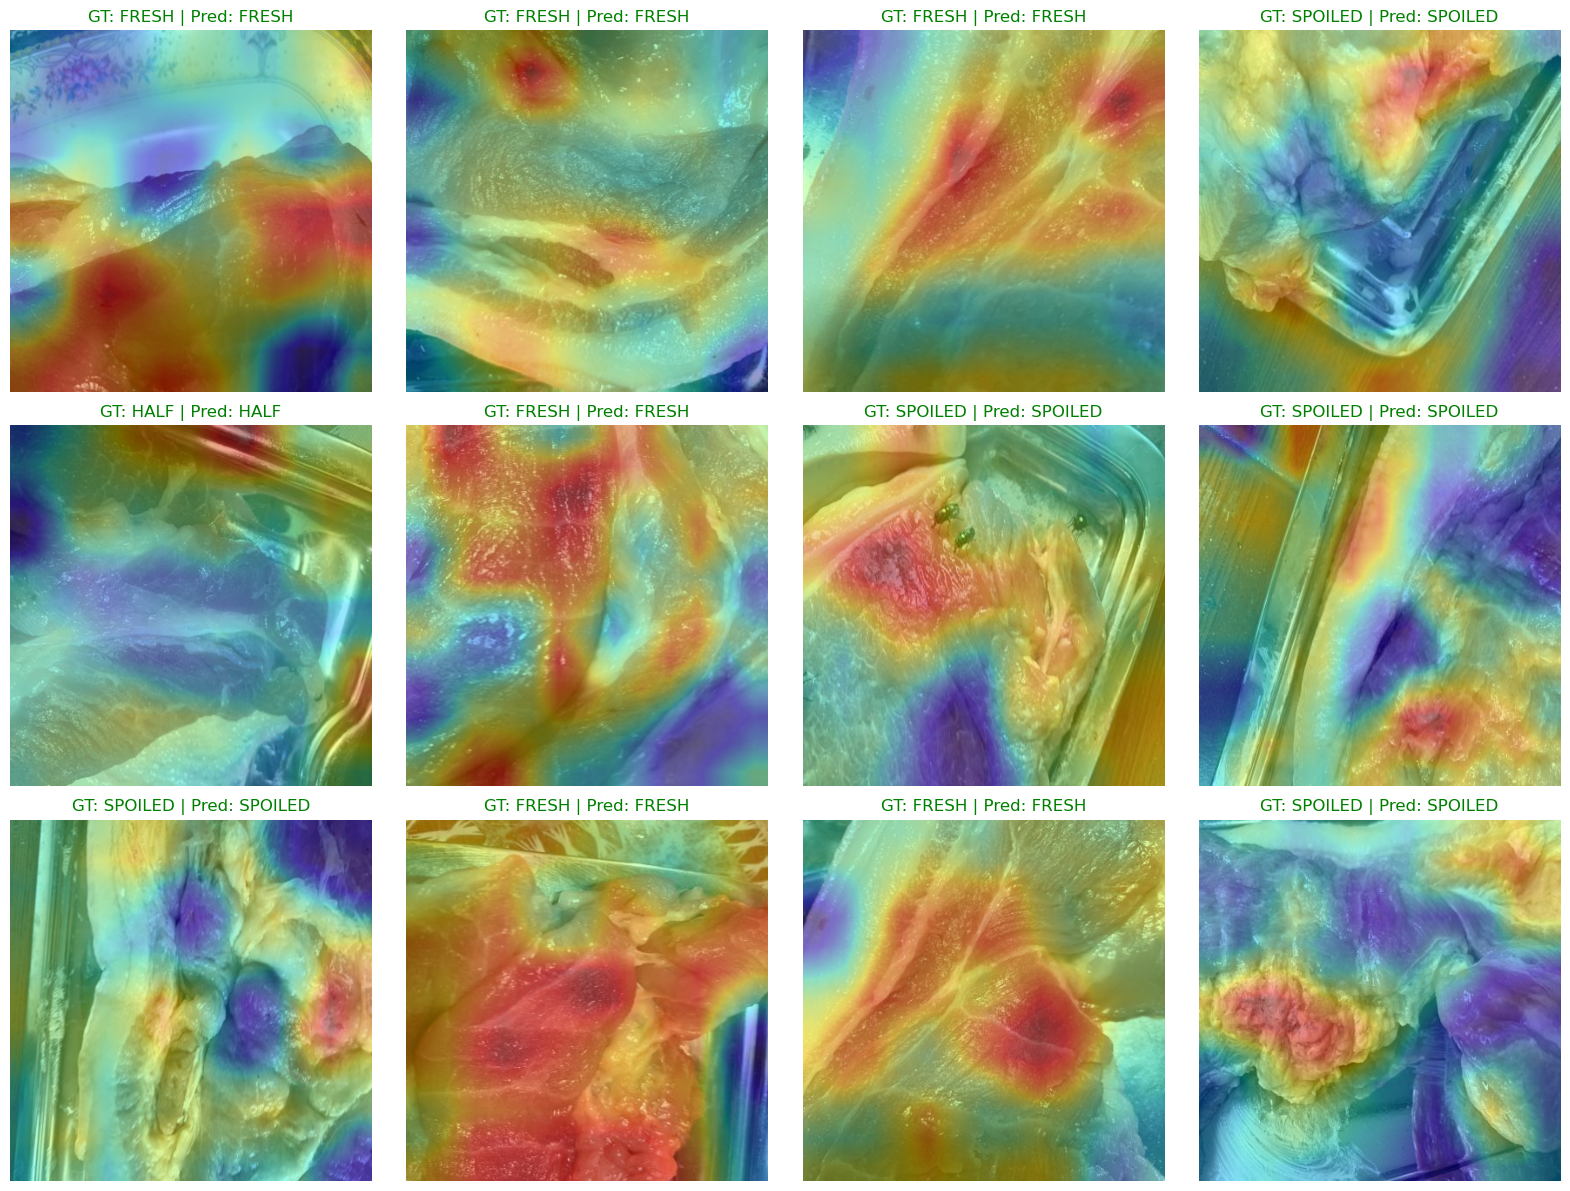

In [20]:
import cv2

def tensor_to_image(t: torch.Tensor):
    # normalized tensor (3,H,W) -> uint8 image (H,W,3)
    t = t.detach().cpu().clone()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    t = t * std + mean
    t = torch.clamp(t, 0, 1)
    img = (t.permute(1, 2, 0).numpy() * 255).astype(np.uint8)
    return img

class SaveFeatures:
    def __init__(self, module):
        self.features = None
        self.hook = module.register_forward_hook(self.hook_fn)

    def hook_fn(self, module, inputs, output):
        self.features = output.detach().cpu().numpy()

    def remove(self):
        self.hook.remove()

def get_cam(conv_fs, linear_weights, class_idx):
    _, chs, h, w = conv_fs.shape
    cam = linear_weights[class_idx].dot(conv_fs[0].reshape(chs, h * w))
    cam = cam.reshape(h, w)
    cam = cam - cam.min()
    cam = cam / (cam.max() + 1e-8)
    return cam

@torch.no_grad()
def show_cam_examples(model, loader, num_images=12, rows=3):
    model.eval()

    # ResNet50 specifics
    final_conv = model.layer4
    fc_weight = model.fc.weight.detach().cpu().numpy()

    hook = SaveFeatures(final_conv)

    ims_list, gt_list, pred_list = [], [], []
    for ims, gts in loader:
        ims = ims.to(DEVICE)
        gts = torch.as_tensor(gts, device=DEVICE).long()
        logits = model(ims)
        pred = logits.argmax(dim=1)

        ims_list.append(ims.detach().cpu())
        gt_list.append(int(gts.item()))
        pred_list.append(int(pred.item()))

        if len(ims_list) >= num_images:
            break

    cols = int(math.ceil(num_images / rows))
    plt.figure(figsize=(4 * cols, 4 * rows))

    for i in range(len(ims_list)):
        ims = ims_list[i].to(DEVICE)
        _ = model(ims)  # trigger hook for this image
        cam = get_cam(hook.features, fc_weight, pred_list[i])

        img = tensor_to_image(ims_list[i].squeeze(0))
        cam_resized = cv2.resize(cam, (cfg.IMG_SIZE, cfg.IMG_SIZE), interpolation=cv2.INTER_LINEAR)

        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.imshow(cam_resized, alpha=0.4, cmap="jet")
        plt.axis("off")

        gt_name = target_names[gt_list[i]]
        pr_name = target_names[pred_list[i]]
        plt.title(f"GT: {gt_name} | Pred: {pr_name}", color=("green" if gt_list[i] == pred_list[i] else "red"))

    hook.remove()
    plt.tight_layout()
    plt.show()

# Example:
show_cam_examples(model, test_dl, num_images=12, rows=3)